<a href="https://colab.research.google.com/github/Aayush360/Fast_AI/blob/master/Training_a_digit_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#hide
!pip install fastai --upgrade
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

     |████████████████████████████████| 358kB 3.4MB/s 
  Found existing installation: fastai 1.0.61
    Uninstalling fastai-1.0.61:
      Successfully uninstalled fastai-1.0.61
     |████████████████████████████████| 727kB 3.4MB/s 
     |████████████████████████████████| 61kB 6.5MB/s 
     |████████████████████████████████| 1.0MB 20.2MB/s 
     |████████████████████████████████| 51kB 5.8MB/s 
     |████████████████████████████████| 92kB 8.3MB/s 
     |████████████████████████████████| 40kB 4.7MB/s 
     |████████████████████████████████| 51kB 5.5MB/s 
     |████████████████████████████████| 61kB 6.8MB/s 
     |████████████████████████████████| 2.6MB 21.4MB/s 
Mounted at /content/gdrive


In [2]:
#hide
from fastbook import *
from fastai.vision.widgets import *

In [3]:
path = untar_data(URLs.MNIST_SAMPLE)

In [4]:
path.ls()

(#3) [Path('/root/.fastai/data/mnist_sample/labels.csv'),Path('/root/.fastai/data/mnist_sample/valid'),Path('/root/.fastai/data/mnist_sample/train')]

In [5]:
# what's inside the training set
(path/'train').ls()

(#2) [Path('/root/.fastai/data/mnist_sample/train/3'),Path('/root/.fastai/data/mnist_sample/train/7')]

In [6]:
threes = (path/'train'/'3').ls().sorted()
sevens = (path/'train'/'7').ls().sorted()
threes

(#6131) [Path('/root/.fastai/data/mnist_sample/train/3/10.png'),Path('/root/.fastai/data/mnist_sample/train/3/10000.png'),Path('/root/.fastai/data/mnist_sample/train/3/10011.png'),Path('/root/.fastai/data/mnist_sample/train/3/10031.png'),Path('/root/.fastai/data/mnist_sample/train/3/10034.png'),Path('/root/.fastai/data/mnist_sample/train/3/10042.png'),Path('/root/.fastai/data/mnist_sample/train/3/10052.png'),Path('/root/.fastai/data/mnist_sample/train/3/1007.png'),Path('/root/.fastai/data/mnist_sample/train/3/10074.png'),Path('/root/.fastai/data/mnist_sample/train/3/10091.png')...]

In [7]:
# looking at an individual image
im3_path = threes[1]
im3 = Image.open(im3_path)
im3

In [8]:
array(im3)[4:10,4:10]

array([[  0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,  29],
       [  0,   0,   0,  48, 166, 224],
       [  0,  93, 244, 249, 253, 187],
       [  0, 107, 253, 253, 230,  48],
       [  0,   3,  20,  20,  15,   0]], dtype=uint8)

In [9]:
# using tensor instead of array

tensor(im3)[4:10,4:10]

tensor([[  0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,  29],
        [  0,   0,   0,  48, 166, 224],
        [  0,  93, 244, 249, 253, 187],
        [  0, 107, 253, 253, 230,  48],
        [  0,   3,  20,  20,  15,   0]], dtype=torch.uint8)

In [10]:
# looking at the portion of the image

im3_t = tensor(im3)
df = pd.DataFrame(im3_t[4:15,4:22])
df.style.set_properties(**{'font-size':'6pt'}).background_gradient('Greys')

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,29,150,195,254,255,254,176,193,150,96,0,0,0
2,0,0,0,48,166,224,253,253,234,196,253,253,253,253,233,0,0,0
3,0,93,244,249,253,187,46,10,8,4,10,194,253,253,233,0,0,0
4,0,107,253,253,230,48,0,0,0,0,0,192,253,253,156,0,0,0
5,0,3,20,20,15,0,0,0,0,0,43,224,253,245,74,0,0,0
6,0,0,0,0,0,0,0,0,0,0,249,253,245,126,0,0,0,0
7,0,0,0,0,0,0,0,14,101,223,253,248,124,0,0,0,0,0
8,0,0,0,0,0,11,166,239,253,253,253,187,30,0,0,0,0,0
9,0,0,0,0,0,16,248,250,253,253,253,253,232,213,111,2,0,0


## Start By creating a simple version of the model (which is easy to implement) to check how it works 

In [11]:
# create a list of single image tensors

seven_tensors = [tensor(Image.open(o)) for o in sevens]
three_tensors = [tensor(Image.open(o)) for o in threes]

len(seven_tensors),len(three_tensors)

(6265, 6131)

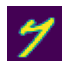

In [12]:
show_image(seven_tensors[1]);

In [13]:
# stacking the tensor into a rank-3 tensor

stacked_sevens = torch.stack(seven_tensors).float()/255
stacked_threes = torch.stack(three_tensors).float()/255 # normalizing the pixels

In [14]:
stacked_sevens.shape

torch.Size([6265, 28, 28])

In [15]:
# length of tensor's shape is its rank

len(stacked_sevens.shape)

3

In [16]:
stacked_threes.ndim # we can get rank this way also

3

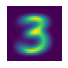

In [17]:
# computing average of pixel over all images, along dimension 0

mean3 = stacked_threes.mean(0)
show_image(mean3);



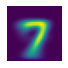

In [18]:
mean7 = stacked_sevens.mean(0)
show_image(mean7);

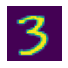

In [19]:
a_3 = stacked_threes[1]
show_image(a_3);

In [20]:
# to find the differences between the actual(sample image) and the ideal image(being averaged across pixels) we can either use L1 OR L2 Norm

In [21]:
dist_3_abs = (a_3-mean3).abs().mean()
dist_3_sqr = ((a_3-mean3)**2).mean().sqrt()
dist_3_abs, dist_3_sqr

(tensor(0.1114), tensor(0.2021))

In [22]:
# difference between 3 and ideal_7

dist_7_abs = (a_3-mean7).abs().mean()
dist_7_sqr = ((a_3-mean7)**2).mean().sqrt()
dist_7_abs, dist_7_sqr

(tensor(0.1586), tensor(0.3021))

In [23]:
## analysis: distance of 3 to mean of 3 is less than distance of 3 to mean of 7

In [24]:
# alternatively, 

F.l1_loss(a_3, mean7),F.mse_loss(a_3, mean7).sqrt()

(tensor(0.1586), tensor(0.3021))

## Checking how or baseline model performs: using a metric for evaluation

In [25]:
## create tensor from our validation set to see how our model performs - using accuracy as evaluation metric

In [26]:
valid_3_tens = torch.stack([tensor(Image.open(o)) for o in (path/'valid'/'3').ls()])
valid_3_tens = valid_3_tens.float()/255
valid_7_tens = torch.stack([tensor(Image.open(o)) for o in (path/'valid'/'7').ls()])
valid_7_tens = valid_7_tens.float()/255

valid_3_tens.shape, valid_7_tens.shape

(torch.Size([1010, 28, 28]), torch.Size([1028, 28, 28]))

In [27]:
def mnist_distance(a,b): return (a-b).abs().mean((-1,-2)) # excluding the first axes which is the image number itself
mnist_distance(a_3,mean3)

tensor(0.1114)

In [28]:
valid_3_dist= mnist_distance(valid_3_tens,mean3)
valid_3_dist, valid_3_dist.shape

(tensor([0.1163, 0.1236, 0.1247,  ..., 0.1531, 0.1335, 0.1093]),
 torch.Size([1010]))

In [29]:
(valid_3_tens-mean3).shape

torch.Size([1010, 28, 28])

In [30]:
# function to determine if the given number is 3

def is_3(x): return mnist_distance(x,mean3) < mnist_distance(x,mean7)

In [31]:
# to check for a_3

is_3(a_3), is_3(a_3).float()

(tensor(True), tensor(1.))

In [32]:
# checking for one of the number from our validation set
is_3(valid_3_tens[1])

tensor(True)

In [33]:
# using broadcasting to check on the entire validation set

accuracy_3s = is_3(valid_3_tens).float().mean()
accuracy_7s = (1-(is_3(valid_7_tens).float())).mean()

accuracy_3s, accuracy_7s, (accuracy_3s+accuracy_7s)/2

(tensor(0.9168), tensor(0.9854), tensor(0.9511))

## Model that does real learning, one that can autocmatically modify itself to improve its performance

In [34]:
## let's assume our loss fucntion is a simple quadratic function which we aim to minimize

In [35]:
def f(x): return x**2

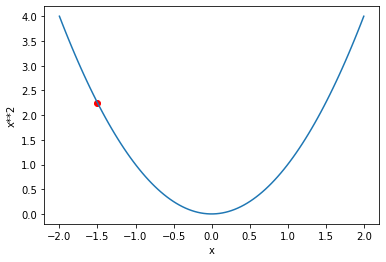

In [36]:
plot_function(f, 'x','x**2')
plt.scatter(-1.5,f(-1.5), color='red');

In [37]:
# using pytorch to perform derivative

In [38]:
xt = tensor(3.).requires_grad_()

In [39]:
yt = f(xt)
yt

tensor(9., grad_fn=<PowBackward0>)

In [40]:
# performing backpropagation for calculating gradient
yt.backward()

In [41]:
# calculating the value of the grdient
xt.grad

tensor(6.)

In [42]:
# using the vectorized implementation for calculating the backpropagation

xt = tensor([3.,4.,10.]).requires_grad_()
xt

tensor([ 3.,  4., 10.], requires_grad=True)

In [43]:
def f(x):return (x**2).sum()

yt = f(xt)
yt

tensor(125., grad_fn=<SumBackward0>)

In [44]:
yt.backward()
xt.grad

tensor([ 6.,  8., 20.])

In [45]:
## An end to end example of SGD

In [46]:
time = torch.arange(0,20).float(); time

tensor([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13., 14., 15., 16., 17., 18., 19.])

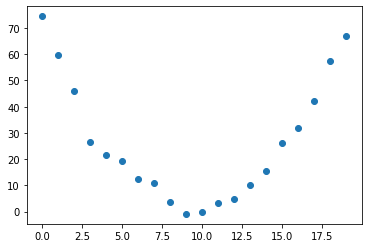

In [47]:
speed = torch.randn(20)*3+ 0.75*(time-9.5)**2+1
plt.scatter(time,speed);

In [48]:
# function to separate input and parameters

def f(t, params):
  a,b,c=params
  return a*(t**2) +(b*t)+c

In [49]:
# defining a loss function

def mse(preds, targets): return ((preds-targets)**2).mean()

In [50]:
# finding the best function that is the close approximation of above graph:

# 1: initialize the parameters

params = torch.randn(3).requires_grad_()
params

tensor([-0.7658, -0.7506,  1.3525], requires_grad=True)

In [51]:
# 2: calculate the predictions

preds = f(time, params)
preds

tensor([ 1.3525e+00, -1.6391e-01, -3.2121e+00, -7.7919e+00, -1.3903e+01, -2.1547e+01, -3.0721e+01, -4.1428e+01, -5.3666e+01, -6.7436e+01, -8.2738e+01, -9.9571e+01, -1.1794e+02, -1.3783e+02,
        -1.5926e+02, -1.8222e+02, -2.0671e+02, -2.3274e+02, -2.6029e+02, -2.8938e+02], grad_fn=<AddBackward0>)

In [52]:
# let's see our close our prediction is to the target

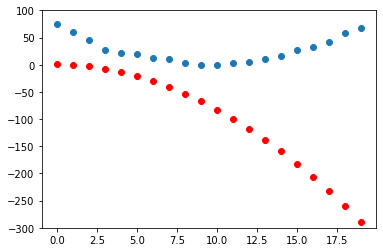

In [53]:
def show_preds(preds, ax=None):
  if ax is None: ax=plt.subplots()[1]
  ax.scatter(time, speed)
  ax.scatter(time, to_np(preds), color='red')
  ax.set_ylim(-300,100)
show_preds(preds)

In [54]:
# 3: calculate the loss

loss = mse(preds, speed)
loss

tensor(25823.8086, grad_fn=<MeanBackward0>)

Our goal is to minimize this loss, we do it using the gradients

In [55]:
# 4: Calcualte the gradient

loss.backward() # backprop the loss
params.grad # caculate gradeint wrt to parameters

tensor([-53195.8594,  -3419.7146,   -253.8908])

In [56]:
params.grad*1e-5

tensor([-0.5320, -0.0342, -0.0025])

In [57]:
params # we will use these gradient to improve our parameters

tensor([-0.7658, -0.7506,  1.3525], requires_grad=True)

In [58]:
# 5: Step the weights

lr = 1e-5
params.data-=lr*params.grad.data
params.grad=None

In [59]:
preds = f(time, params)
mse(preds,speed)

tensor(5435.5366, grad_fn=<MeanBackward0>)

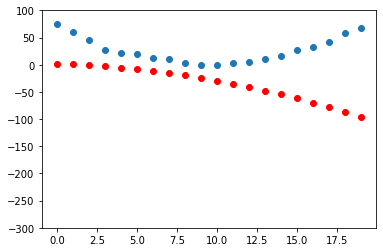

In [60]:
show_preds(preds)

In [61]:
def apply_step(params, prn=True):
  preds = f(time,params)
  loss = mse(preds, speed)
  loss.backward()
  params.data-=lr* params.grad.data
  params.grad=None
  if prn: print(loss.item())
  return preds

In [62]:
# 6: Step the process

# for i in range(10): apply_step(params)

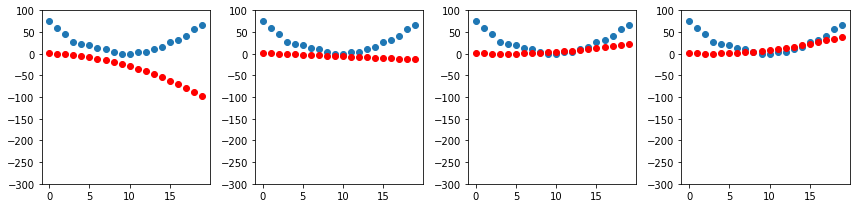

In [63]:
# plotting how the function changes with iterations:
_,axs = plt.subplots(1,4,figsize=(12,3))
for ax in axs: show_preds(apply_step(params,False),ax)
plt.tight_layout()

## The MNIST loss function

In [64]:
# stacking up the training data and changing from rank-3 (list of Matrices) to rank-2 (list of vectors)

In [65]:
train_x = torch.cat([stacked_threes, stacked_sevens]).view(-1, 28*28)

In [66]:
# creating a label

train_y = tensor([1]*len(threes)+[0]*len(sevens)).unsqueeze(1)

In [67]:
len([1]*len(threes)+[0]*len(sevens))

12396

In [68]:
train_x.shape, train_y.shape

(torch.Size([12396, 784]), torch.Size([12396, 1]))

In [69]:
# combining features and label with zip to create datsets

dset = list(zip(train_x, train_y))
x,y = dset[0]
x.shape, y

(torch.Size([784]), tensor([1]))

In [70]:
# creating a dataset for validation set

valid_x = torch.cat([valid_3_tens, valid_7_tens]).view(-1,28*28)
valid_y = tensor([1]*len(valid_3_tens)+[0]*len(valid_7_tens)).unsqueeze(1)
valid_dset= list(zip(valid_x, valid_y))

In [71]:
# 1: initialize random weights for every pixel and also biases

def init_params(size, std=1.0): return (torch.randn(size)*std).requires_grad_()
weights = init_params((28*28,1))
bias = init_params(1)

In [72]:
weights.shape

torch.Size([784, 1])

In [73]:
# calculating prediction for single image

In [74]:
(train_x[0]*weights.T).sum()+bias

tensor([20.2336], grad_fn=<AddBackward0>)

In [75]:
# using matrix_mul

def linear1(xb): return xb@weights+bias
preds = linear1(train_x)
preds

tensor([[20.2336],
        [17.0644],
        [15.2384],
        ...,
        [18.3804],
        [23.8567],
        [28.6816]], grad_fn=<AddBackward0>)

In [76]:
(preds>0.0).float()

tensor([[1.],
        [1.],
        [1.],
        ...,
        [1.],
        [1.],
        [1.]])

In [77]:
corrects = (preds>0.0).float()==train_y
corrects

tensor([[ True],
        [ True],
        [ True],
        ...,
        [False],
        [False],
        [False]])

In [78]:
corrects.float().mean().item()

0.4912068545818329

In [79]:
# let's change a single weight to see how our accuracy changes

weights[0]*=1.0001
preds = linear1(train_x)
((preds>0.0).float()==train_y).float().mean().item()

0.4912068545818329

In [80]:
trgts =tensor([1,0,1])
prds = tensor([0.9,0.4,0.2])

In [81]:
# defining a loss function

def mnist_loss(predictions, targets):
  return torch.where(targets==1, 1-predictions, predictions).mean()

In [82]:
torch.where(trgts==1,1-prds,prds)

tensor([0.1000, 0.4000, 0.8000])

In [83]:
mnist_loss(prds,trgts)

tensor(0.4333)

In [84]:
mnist_loss(tensor([0.9,0.4,0.8]),trgts)

# loss goes down

tensor(0.2333)

## Sigmoid activation function

In [85]:
def sigmoid(x): return 1/(1+torch.exp(-x))

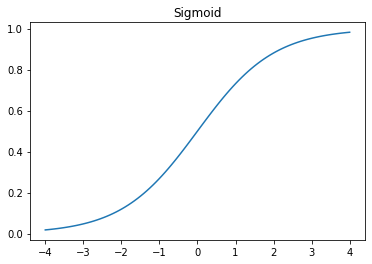

In [86]:
plot_function(torch.sigmoid, title='Sigmoid',min=-4, max=4)

In [87]:
def mnist_loss(predictions, targets):
  predictions = predictions.sigmoid()
  return torch.where(targets==1, 1-predictions, predictions).mean()

In [88]:
coll = range(15)
dl = DataLoader(coll, batch_size=5, shuffle=True)
list(dl)

[tensor([ 3, 12,  8, 10,  2]),
 tensor([ 9,  4,  7, 14,  5]),
 tensor([ 1, 13,  0,  6, 11])]

In [89]:
# a datset contains tuples of independent and dependent variable

In [90]:
ds = L(enumerate(string.ascii_lowercase))
ds

(#26) [(0, 'a'),(1, 'b'),(2, 'c'),(3, 'd'),(4, 'e'),(5, 'f'),(6, 'g'),(7, 'h'),(8, 'i'),(9, 'j')...]

In [91]:
dl = DataLoader(ds,bs=6,shuffle=True)
list(dl)

[(tensor([17, 18, 10, 22,  8, 14]), ('r', 's', 'k', 'w', 'i', 'o')),
 (tensor([20, 15,  9, 13, 21, 12]), ('u', 'p', 'j', 'n', 'v', 'm')),
 (tensor([ 7, 25,  6,  5, 11, 23]), ('h', 'z', 'g', 'f', 'l', 'x')),
 (tensor([ 1,  3,  0, 24, 19, 16]), ('b', 'd', 'a', 'y', 't', 'q')),
 (tensor([2, 4]), ('c', 'e'))]

In [92]:
# for x,y in dl:
#   pred = model(x)
#   loss = loss_func(pred,y)
#   loss.backward()
#   parameters-=parameters.grad*lr

In [93]:
weights = init_params((28*28,1))
bias = init_params(1)

In [94]:
# create dataloader from the datset

dl = DataLoader(dset, batch_size=256)
xb,yb = first(dl)
xb.shape,yb.shape

(torch.Size([256, 784]), torch.Size([256, 1]))

In [95]:
valid_dl = DataLoader(valid_dset,batch_size=256)

In [96]:
# create a mini-batch of size 4 for testing

batch = train_x[:4]
batch.shape

torch.Size([4, 784])

In [97]:
preds = linear1(batch)
preds

tensor([[-2.1876],
        [-8.3973],
        [ 2.5000],
        [-4.9473]], grad_fn=<AddBackward0>)

In [98]:
loss = mnist_loss(preds, train_y[:4])
loss

tensor(0.7419, grad_fn=<MeanBackward0>)

In [99]:
loss.backward()
weights.grad.shape, weights.grad.mean(),bias.grad

(torch.Size([784, 1]), tensor(-0.0061), tensor([-0.0420]))

In [100]:
def calc_grad(xb,yb,model):
  preds = model(xb)
  loss=mnist_loss(preds,yb)
  loss.backward()

In [101]:
calc_grad(batch,train_y[:4],linear1)
weights.grad.mean(), bias.grad

(tensor(-0.0121), tensor([-0.0840]))

In [102]:
calc_grad(batch,train_y[:4],linear1)
weights.grad.mean(), bias.grad

(tensor(-0.0182), tensor([-0.1260]))

In [103]:
weights.grad.zero_()
bias.grad.zero_()

tensor([0.])

In [105]:
# update weights and bias based on gradient and learning rate

In [106]:
def train_epoch(model, lr, params):
  for xb,yb in dl:
    calc_grad(xb, yb, model)
    for p in params:
      p.data-=p.grad*lr
      p.grad.zero_()

In [107]:
# to calculate validation_accuracy

def batch_accuracy(xb,yb):
  preds = xb.sigmoid()
  correct = (preds>0.5)==yb
  return correct.float().mean()

In [108]:
batch = train_x[:4]


In [109]:
# let's check how it works for our batch

batch_accuracy(linear1(batch), train_y[:4])

tensor(0.2500)

In [124]:
# putting the batches together

def validate_epoch(model):
  accs = [batch_accuracy(model(xb),yb) for xb,yb in valid_dl]
  return round(torch.stack(accs).mean().item(),4)

validate_epochs(linear1)

0.9735

In [111]:
# let's train for one epoch and see if the accuracy improves

In [112]:
weights = init_params((28*28,1))
bias = init_params(1)

In [114]:
lr = 1.
params = weights, bias
train_epoch(linear1,lr, params)
validate_epoch(linear1)

0.7015

In [115]:
# doing it few more times

for i in range(20):
  train_epoch(linear1,lr,params)
  print(validate_epoch(linear1), end=' ')

0.87 0.9188 0.9359 0.9466 0.9505 0.9554 0.9578 0.9593 0.9607 0.9622 0.9647 0.9652 0.9671 0.9686 0.9695 0.9705 0.9705 0.9725 0.9725 0.9735 

In [116]:
# using Pytorch nn.Linear module that performs the work of init_params and linear1 combined

In [117]:
linear_model = nn.Linear(28*28,1)

In [118]:
w,b = linear_model.parameters()
w.shape, b.shape

(torch.Size([1, 784]), torch.Size([1]))

In [119]:
# creating the optimizer

In [120]:
class BasicOptim:
  def __init__(self,params, lr): self.params, self.lr = list(params), lr

  def step(self,*args, **kwargs):
    for p in self.params: p.data-= p.grad.data*self.lr
  
  def zero_grad(self, *args, **kwargs):
    for p in self.params: p.grad = None

In [121]:
opt = BasicOptim(linear_model.parameters(),lr)

In [122]:
def train_epoch(model):
  for xb,yb in dl:
    calc_grad(xb,yb,model)
    opt.step()
    opt.zero_grad()


In [125]:
validate_epoch(linear_model)

0.3448

In [126]:
def train_model(model, epochs):
  for i in range(epochs):
    train_epoch(model)
    print(validate_epoch(model), end=' ')

In [128]:
train_model(linear_model,20)

0.4932 0.8935 0.811 0.9087 0.9316 0.9467 0.9545 0.9614 0.9653 0.9667 0.9687 0.9716 0.9731 0.9745 0.976 0.9765 0.9775 0.9775 0.978 0.9789 

In [129]:
## we can use the same optimizer named SGD given by fast ai

In [130]:
linear_model = nn.Linear(28*28,1)
opt = SGD(linear_model.parameters(),lr)
train_model(linear_model,20)

0.4932 0.912 0.7988 0.9013 0.9301 0.9448 0.955 0.9609 0.9658 0.9662 0.9692 0.9721 0.9736 0.9745 0.9755 0.9765 0.9775 0.9775 0.978 0.9789 

In [132]:
# we can use Learner.fit instead of train_model

dls = DataLoaders(dl,valid_dl)

In [133]:
learn = Learner(dls,nn.Linear(28*28,1),opt_func=SGD, loss_func=mnist_loss, metrics=batch_accuracy)

In [134]:
learn.fit(10,lr=lr)

epoch,train_loss,valid_loss,batch_accuracy,time
0,0.637017,0.503463,0.495584,00:00
1,0.508525,0.203196,0.823847,00:00
2,0.187568,0.175496,0.842983,00:00
3,0.082690,0.105325,0.913150,00:00
4,0.043984,0.077190,0.931796,00:00
5,0.028817,0.061936,0.947007,00:00
6,0.022560,0.052429,0.956330,00:00
7,0.019766,0.046105,0.962709,00:00
8,0.018343,0.041657,0.965162,00:00
9,0.017485,0.038374,0.966634,00:00


## Adding a Non-Linearity

In [135]:
# In neural-network, we add two non-linearity between two linear function/classifiers.

In [136]:
def simple_net(xb):
  res = xb@w1+b1
  res = res.max(tensor(0.0))
  res = res@w2+b2
  return res

In [137]:
w1 = init_params((28*28,30))
b1 = init_params(30)
w2 = init_params((30,1))
b1 = init_params(1)



In [138]:
w1.shape

torch.Size([784, 30])

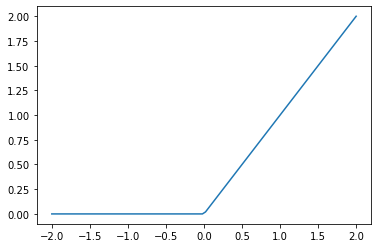

In [139]:
plot_function(F.relu)

In [140]:
simple_net = nn.Sequential(
    nn.Linear(28*28,30),
    nn.ReLU(),
    nn.Linear(30,1)
)

In [144]:
learn = Learner(dls, simple_net, opt_func=SGD, loss_func=mnist_loss, metrics=batch_accuracy)
learn.fit(40,0.1)

epoch,train_loss,valid_loss,batch_accuracy,time
0,0.014021,0.020705,0.981845,00:00
1,0.013939,0.020581,0.981845,00:00
2,0.013846,0.020462,0.982336,00:00
3,0.013747,0.020348,0.982336,00:00
4,0.013647,0.020239,0.982336,00:00
5,0.013546,0.020135,0.982336,00:00
6,0.013447,0.020035,0.982336,00:00
7,0.013350,0.019938,0.982336,00:00
8,0.013254,0.019845,0.982336,00:00
9,0.013161,0.019755,0.982336,00:00


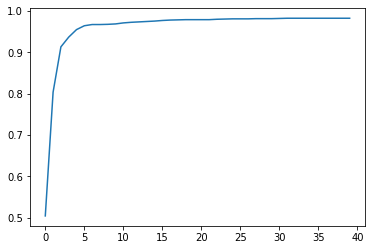

In [142]:
plt.plot(L(learn.recorder.values).itemgot(2));

In [145]:
# final accuracy

learn.recorder.values[-1][2]

0.9847890138626099